In [1]:
import os
import glob
import xml.etree.ElementTree as ET
import random
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import cv2
from tqdm.notebook import tqdm

In [2]:
base_dir = "E:\Datasets\Vision\Sideguide\BBOX\Extracted"

output_folder = "E:\Datasets\Vision\Sideguide\YOLO\YOLO_BBOX"

data_fraction = 0.2

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [3]:
def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[2])/2.0
    y = (box[1] + box[3])/2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x, y, w, h)

def find_all_files():
    all_xml_files = []
    all_image_files = []
    
    for first_level in tqdm(os.listdir(base_dir), desc="Processing first level folders"):
        first_level_path = os.path.join(base_dir, first_level)
        if not os.path.isdir(first_level_path):
            continue

        for second_level in tqdm(os.listdir(first_level_path), desc=f"Processing {first_level}", leave=False):
            second_level_path = os.path.join(first_level_path, second_level)
            if not os.path.isdir(second_level_path):
                continue
                
            files = os.listdir(second_level_path)

            xml_files = [os.path.join(second_level_path, f) for f in files if f.endswith('.xml')]

            img_files = []
            for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                img_files.extend([os.path.join(second_level_path, f) for f in files if f.endswith(ext)])

            all_xml_files.extend(xml_files)
            all_image_files.extend(img_files)
    
    print(f"Found {len(all_xml_files)} XML files and {len(all_image_files)} image files")
    return all_xml_files, all_image_files

def process_cvat_xml(xml_file, image_files):
    all_classes = set()
    dataset = []

    image_lookup = {}
    for img_path in image_files:
        img_name = os.path.basename(img_path)
        image_lookup[img_name] = img_path
    
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        labels_section = root.find('.//task/labels')
        if labels_section:
            for label in labels_section.findall('.//label/name'):
                all_classes.add(label.text)

        for image in root.findall('.//image'):
            img_name = image.get('name')
            width = int(image.get('width'))
            height = int(image.get('height'))

            img_path = image_lookup.get(img_name)
            
            if img_path:
                objects = []
                for box in image.findall('box'):
                    label = box.get('label')
                    xtl = float(box.get('xtl'))
                    ytl = float(box.get('ytl'))
                    xbr = float(box.get('xbr'))
                    ybr = float(box.get('ybr'))
                    
                    objects.append({
                        'class': label,
                        'bbox': [xtl, ytl, xbr, ybr]
                    })
                
                if objects:
                    dataset.append({
                        'xml_file': xml_file,
                        'img_file': img_path,
                        'width': width,
                        'height': height,
                        'objects': objects
                    })
    except Exception as e:
        print(f"Error processing CVAT XML {xml_file}: {e}")
    
    return list(all_classes), dataset

In [4]:
all_xml_files, all_image_files = find_all_files()

if data_fraction < 1.0 and all_xml_files:
    random.shuffle(all_xml_files)
    all_xml_files = all_xml_files[:int(len(all_xml_files) * data_fraction)]
    print(f"Using {len(all_xml_files)} XML files ({data_fraction*100:.1f}% of total)")

all_classes = set()
dataset = []

for xml_file in tqdm(all_xml_files, desc="Processing XML files"):
    classes, data = process_cvat_xml(xml_file, all_image_files)
    all_classes.update(classes)
    dataset.extend(data)

classes = sorted(list(all_classes))
print(f"Found {len(classes)} unique classes: {classes}")
print(f"Successfully matched {len(dataset)} XML-image pairs")
print(f"Total dataset entries: {len(dataset)}")

Processing first level folders:   0%|          | 0/7 [00:00<?, ?it/s]

Processing Bbox_1_new:   0%|          | 0/150 [00:00<?, ?it/s]

Processing Bbox_2_new:   0%|          | 0/100 [00:00<?, ?it/s]

Processing Bbox_3_new:   0%|          | 0/90 [00:00<?, ?it/s]

Processing Bbox_4_new:   0%|          | 0/70 [00:00<?, ?it/s]

Processing Bbox_5_new:   0%|          | 0/60 [00:00<?, ?it/s]

Processing Bbox_6_new:   0%|          | 0/60 [00:00<?, ?it/s]

Processing Bbox_7_new:   0%|          | 0/60 [00:00<?, ?it/s]

Found 590 XML files and 140122 image files
Using 118 XML files (20.0% of total)


Processing XML files:   0%|          | 0/118 [00:00<?, ?it/s]

Found 29 unique classes: ['barricade', 'bench', 'bicycle', 'bollard', 'bus', 'car', 'carrier', 'cat', 'chair', 'dog', 'fire_hydrant', 'kiosk', 'motorcycle', 'movable_signage', 'parking_meter', 'person', 'pole', 'potted_plant', 'power_controller', 'scooter', 'stop', 'stroller', 'table', 'traffic_light', 'traffic_light_controller', 'traffic_sign', 'tree_trunk', 'truck', 'wheelchair']
Successfully matched 28518 XML-image pairs
Total dataset entries: 28518


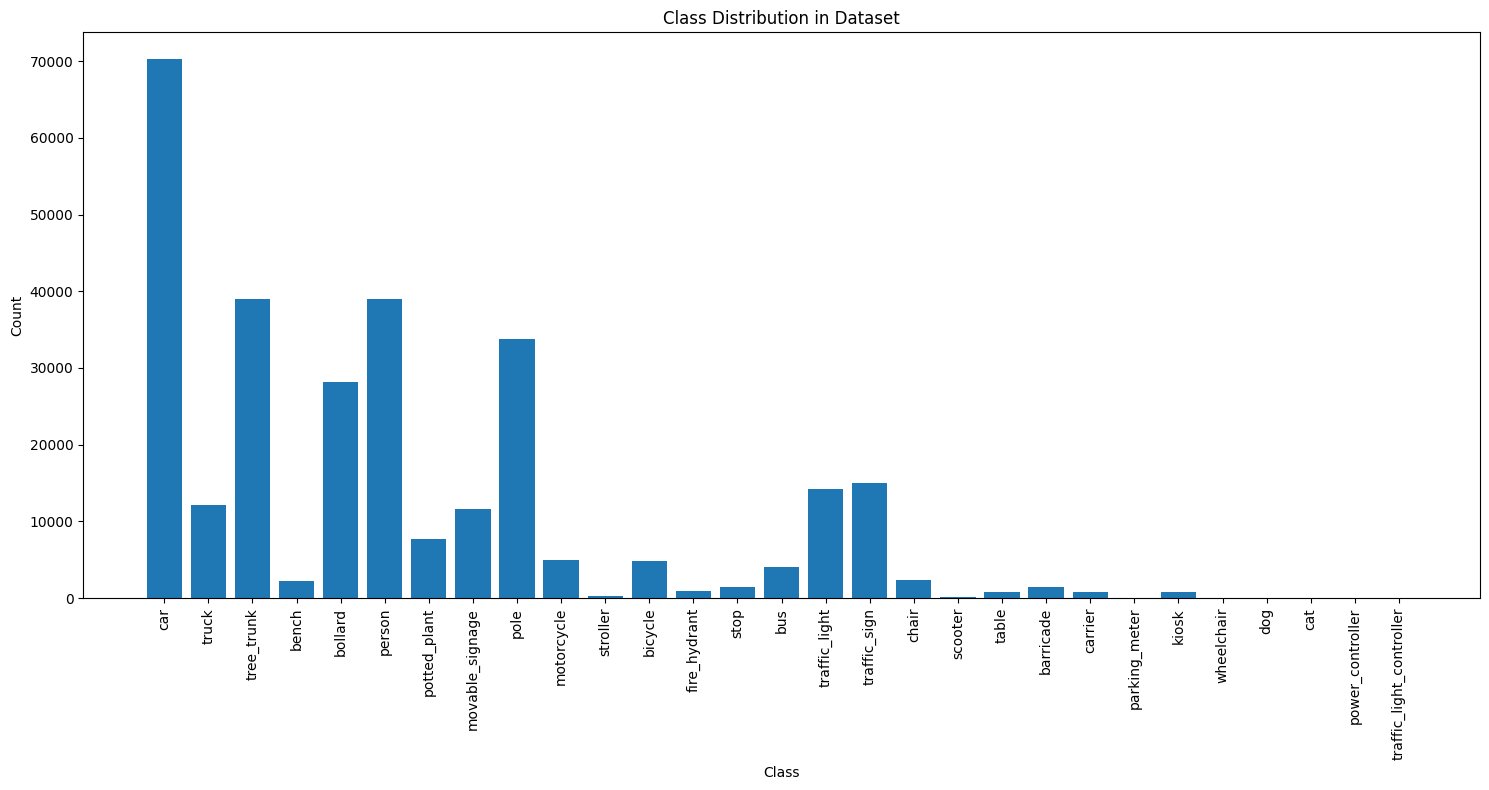

Class distribution:
car: 70250 (23.69%)
tree_trunk: 39005 (13.15%)
person: 39005 (13.15%)
pole: 33815 (11.40%)
bollard: 28215 (9.51%)
traffic_sign: 15066 (5.08%)
traffic_light: 14270 (4.81%)
truck: 12202 (4.11%)
movable_signage: 11615 (3.92%)
potted_plant: 7758 (2.62%)
motorcycle: 4971 (1.68%)
bicycle: 4857 (1.64%)
bus: 4052 (1.37%)
chair: 2401 (0.81%)
bench: 2288 (0.77%)
stop: 1443 (0.49%)
barricade: 1418 (0.48%)
fire_hydrant: 938 (0.32%)
carrier: 851 (0.29%)
kiosk: 838 (0.28%)
table: 805 (0.27%)
stroller: 229 (0.08%)
scooter: 108 (0.04%)
dog: 63 (0.02%)
wheelchair: 54 (0.02%)
parking_meter: 44 (0.01%)
cat: 16 (0.01%)
traffic_light_controller: 2 (0.00%)
power_controller: 1 (0.00%)


In [5]:
class_counts = Counter()
for item in dataset:
    for obj in item['objects']:
        class_counts[obj['class']] += 1

plt.figure(figsize=(15, 8))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("Class distribution:")
total_objects = sum(class_counts.values())
for cls, count in class_counts.most_common():
    print(f"{cls}: {count} ({count/total_objects*100:.2f}%)")

In [6]:
def stratified_split(dataset, classes, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    class_files = {cls: [] for cls in classes}
    
    for i, item in enumerate(dataset):
        item_classes = set(obj['class'] for obj in item['objects'])
        for cls in item_classes:
            class_files[cls].append(i)

    train_indices = set()
    val_indices = set()
    test_indices = set()
    
    for cls, indices in class_files.items():
        random.shuffle(indices)

        n_samples = len(indices)
        n_train = int(n_samples * train_ratio)
        n_val = int(n_samples * val_ratio)
        
        cls_train = indices[:n_train]
        cls_val = indices[n_train:n_train + n_val]
        cls_test = indices[n_train + n_val:]
        
        train_indices.update(cls_train)
        val_indices.update(cls_val)
        test_indices.update(cls_test)
    
    val_indices = val_indices - train_indices
    test_indices = test_indices - train_indices - val_indices

    train_data = [dataset[i] for i in train_indices]
    val_data = [dataset[i] for i in val_indices]
    test_data = [dataset[i] for i in test_indices]
    
    return train_data, val_data, test_data

In [7]:
train_data, val_data, test_data = stratified_split(dataset, classes, train_ratio, val_ratio, test_ratio)

print(f"Split dataset into:")
print(f"- Training: {len(train_data)} items ({len(train_data)/len(dataset)*100:.1f}%)")
print(f"- Validation: {len(val_data)} items ({len(val_data)/len(dataset)*100:.1f}%)")
print(f"- Testing: {len(test_data)} items ({len(test_data)/len(dataset)*100:.1f}%)")

train_class_counts = Counter()
val_class_counts = Counter()
test_class_counts = Counter()

for item in train_data:
    for obj in item['objects']:
        train_class_counts[obj['class']] += 1
        
for item in val_data:
    for obj in item['objects']:
        val_class_counts[obj['class']] += 1
        
for item in test_data:
    for obj in item['objects']:
        test_class_counts[obj['class']] += 1

train_total = sum(train_class_counts.values())
val_total = sum(val_class_counts.values())
test_total = sum(test_class_counts.values())

print("\nClass distribution comparison (%):")
print(f"{'Class':<20} {'Original':<10} {'Train':<10} {'Validation':<10} {'Test':<10}")
print("-" * 60)
for cls in classes:
    orig_pct = class_counts[cls]/total_objects*100
    train_pct = train_class_counts.get(cls, 0)/train_total*100 if train_total else 0
    val_pct = val_class_counts.get(cls, 0)/val_total*100 if val_total else 0
    test_pct = test_class_counts.get(cls, 0)/test_total*100 if test_total else 0
    print(f"{cls:<20} {orig_pct:<10.2f} {train_pct:<10.2f} {val_pct:<10.2f} {test_pct:<10.2f}")

Split dataset into:
- Training: 27486 items (96.4%)
- Validation: 669 items (2.3%)
- Testing: 363 items (1.3%)

Class distribution comparison (%):
Class                Original   Train      Validation Test      
------------------------------------------------------------
barricade            0.48       0.48       0.61       0.00      
bench                0.77       0.76       1.33       1.79      
bicycle              1.64       1.64       1.68       0.70      
bollard              9.51       9.59       5.47       2.80      
bus                  1.37       1.38       0.49       0.23      
car                  23.69      23.58      30.92      28.56     
carrier              0.29       0.29       0.26       0.16      
cat                  0.01       0.00       0.03       0.08      
chair                0.81       0.82       0.20       0.31      
dog                  0.02       0.02       0.00       0.00      
fire_hydrant         0.32       0.32       0.14       0.00      
kiosk       

In [8]:
os.makedirs(output_folder, exist_ok=True)

train_img_dir = os.path.join(output_folder, 'train', 'images')
train_lbl_dir = os.path.join(output_folder, 'train', 'labels')
val_img_dir = os.path.join(output_folder, 'valid', 'images')
val_lbl_dir = os.path.join(output_folder, 'valid', 'labels')
test_img_dir = os.path.join(output_folder, 'test', 'images')
test_lbl_dir = os.path.join(output_folder, 'test', 'labels')

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_lbl_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)
os.makedirs(test_lbl_dir, exist_ok=True)

In [9]:
def convert_to_yolo_format(item, output_img_dir, output_lbl_dir, classes):
    """Convert and save a single item to YOLO format"""
    img_file = item['img_file']
    objects = item['objects']
    width = item['width']
    height = item['height']
    
    img_basename = os.path.basename(img_file)
    output_img_path = os.path.join(output_img_dir, img_basename)
    output_lbl_path = os.path.join(output_lbl_dir, os.path.splitext(img_basename)[0] + '.txt')
    
    shutil.copy2(img_file, output_img_path)
    
    with open(output_lbl_path, 'w') as f:
        for obj in objects:
            cls_id = classes.index(obj['class'])
            bbox = obj['bbox']
            bb = convert((width, height), bbox)
            f.write(f"{cls_id} {bb[0]} {bb[1]} {bb[2]} {bb[3]}\n")
    
    return True

print("Converting training data...")
train_success = 0
for item in tqdm(train_data, desc="Processing training data"):
    if convert_to_yolo_format(item, train_img_dir, train_lbl_dir, classes):
        train_success += 1

print("Converting validation data...")
val_success = 0
for item in tqdm(val_data, desc="Processing validation data"):
    if convert_to_yolo_format(item, val_img_dir, val_lbl_dir, classes):
        val_success += 1

print("Converting test data...")
test_success = 0
for item in tqdm(test_data, desc="Processing test data"):
    if convert_to_yolo_format(item, test_img_dir, test_lbl_dir, classes):
        test_success += 1

print(f"Successfully converted:")
print(f"- Training: {train_success}/{len(train_data)} items")
print(f"- Validation: {val_success}/{len(val_data)} items")
print(f"- Testing: {test_success}/{len(test_data)} items")

Converting training data...


Processing training data:   0%|          | 0/27486 [00:00<?, ?it/s]

Converting validation data...


Processing validation data:   0%|          | 0/669 [00:00<?, ?it/s]

Converting test data...


Processing test data:   0%|          | 0/363 [00:00<?, ?it/s]

Successfully converted:
- Training: 27486/27486 items
- Validation: 669/669 items
- Testing: 363/363 items


In [10]:
# data.yaml
with open(os.path.join(output_folder, 'data.yaml'), 'w') as f:
    f.write(f"train: ./train/images\n")
    f.write(f"val: ./valid/images\n")
    f.write(f"test: ./test/images\n\n")
    f.write(f"nc: {len(classes)}\n")
    f.write(f"names: {str(classes)}\n")

print(f"Dataset prepared in {output_folder}")
print(f"Created data.yaml with {len(classes)} classes")

Dataset prepared in E:\Datasets\Vision\Sideguide\YOLO\YOLO_BBOX
Created data.yaml with 29 classes


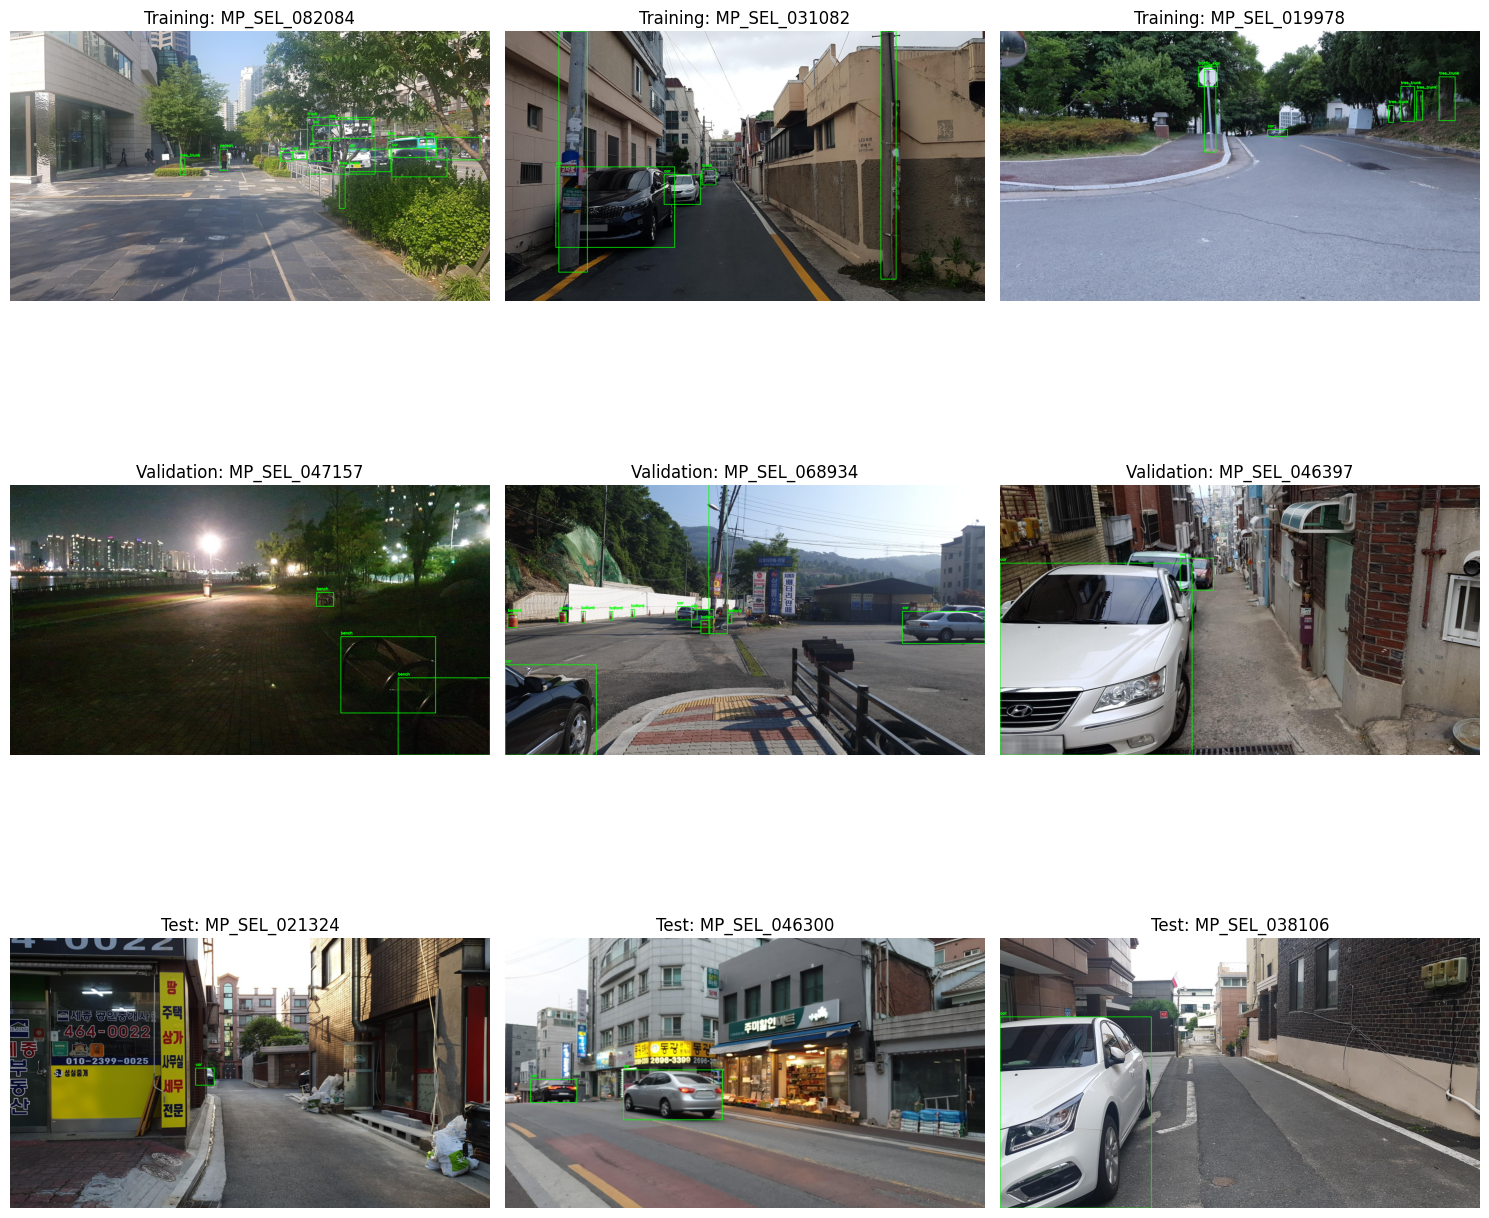

In [11]:
def plot_yolo_box(img, txt_path, class_names):
    height, width, _ = img.shape
    
    if not os.path.exists(txt_path):
        print(f"Label file not found: {txt_path}")
        return img
    
    with open(txt_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            class_id = int(parts[0])
            x_center = float(parts[1]) * width
            y_center = float(parts[2]) * height
            w = float(parts[3]) * width
            h = float(parts[4]) * height
            
            x1 = int(x_center - w/2)
            y1 = int(y_center - h/2)
            x2 = int(x_center + w/2)
            y2 = int(y_center + h/2)
            
            if class_id < len(class_names):
                class_name = class_names[class_id]
            else:
                class_name = f"Class {class_id}"
                
            color = (0, 255, 0)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            
            # Draw label
            cv2.putText(img, class_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img

def verify_random_samples(num_samples=3):
    sets = [
        ("Training", train_img_dir, train_lbl_dir),
        ("Validation", val_img_dir, val_lbl_dir),
        ("Test", test_img_dir, test_lbl_dir)
    ]
    
    plt.figure(figsize=(5*num_samples, 5*len(sets)))
    
    for row_idx, (set_name, img_dir, lbl_dir) in enumerate(sets):
        img_files = os.listdir(img_dir)
        if not img_files:
            print(f"No images found in {img_dir}")
            continue

        random_samples = random.sample(img_files, min(num_samples, len(img_files)))

        for col_idx, img_file in enumerate(random_samples):
            img_path = os.path.join(img_dir, img_file)
            basename = os.path.splitext(img_file)[0]
            txt_path = os.path.join(lbl_dir, f"{basename}.txt")
            
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                annotated_img = plot_yolo_box(img.copy(), txt_path, classes)

                plt.subplot(len(sets), num_samples, row_idx * num_samples + col_idx + 1)
                plt.imshow(annotated_img)
                plt.title(f"{set_name}: {basename}")
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

verify_random_samples(3)

In [12]:
print(f"Dataset summary:")
print(f"Total images: {len(dataset)}")
print(f"Total classes: {len(classes)}")
print(f"Classes: {classes}")
print(f"\nClass counts:")
for cls, count in class_counts.most_common():
    print(f"- {cls}: {count}")

random_label_files = []
if os.path.exists(train_lbl_dir) and os.listdir(train_lbl_dir):
    random_label_files = random.sample(os.listdir(train_lbl_dir), min(3, len(os.listdir(train_lbl_dir))))

print("\nSample label file contents:")
for label_file in random_label_files:
    print(f"\nContents of {label_file}:")
    with open(os.path.join(train_lbl_dir, label_file), 'r') as f:
        print(f.read())

Dataset summary:
Total images: 28518
Total classes: 29
Classes: ['barricade', 'bench', 'bicycle', 'bollard', 'bus', 'car', 'carrier', 'cat', 'chair', 'dog', 'fire_hydrant', 'kiosk', 'motorcycle', 'movable_signage', 'parking_meter', 'person', 'pole', 'potted_plant', 'power_controller', 'scooter', 'stop', 'stroller', 'table', 'traffic_light', 'traffic_light_controller', 'traffic_sign', 'tree_trunk', 'truck', 'wheelchair']

Class counts:
- car: 70250
- tree_trunk: 39005
- person: 39005
- pole: 33815
- bollard: 28215
- traffic_sign: 15066
- traffic_light: 14270
- truck: 12202
- movable_signage: 11615
- potted_plant: 7758
- motorcycle: 4971
- bicycle: 4857
- bus: 4052
- chair: 2401
- bench: 2288
- stop: 1443
- barricade: 1418
- fire_hydrant: 938
- carrier: 851
- kiosk: 838
- table: 805
- stroller: 229
- scooter: 108
- dog: 63
- wheelchair: 54
- parking_meter: 44
- cat: 16
- traffic_light_controller: 2
- power_controller: 1

Sample label file contents:

Contents of MP_SEL_086917.txt:
26 0.90